In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [4]:
%%time
# check if the env is already dry, so it's not affected by MCSs
year_list = np.arange(2010,2021)

for year in [2014]:
    dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))

CPU times: user 1.65 s, sys: 272 ms, total: 1.93 s
Wall time: 2 s


In [110]:
mcs_duration = data_track.mcs_duration
idx_LL = np.where(np.logical_and(mcs_duration >= 24, mcs_duration < 72))[0]
idx_SL = np.where(mcs_duration < 12)[0]
data_track_LL = data_track.isel(tracks=idx_LL)

In [61]:
def get_era5_3dvars(time, lat, lon, deg_range=5):
    
    dt_stamp = pd.to_datetime(time.values)
    month = dt_stamp.month
    day = dt_stamp.day
    hr = dt_stamp.hour
    
    data_t = xr.open_dataset(era5_dir / 'era-5.T.{}.{}.nc'.format(year
                                ,str(month).zfill(2))).sel(time=dt_stamp, method='nearest')
    data_q = xr.open_dataset(era5_dir / 'era-5.q.{}.{}.nc'.format(year
                                ,str(month).zfill(2))).sel(time=dt_stamp, method='nearest')
    data_2t = xr.open_dataset(era5_dir / 'era-5.2t.{}.{}.nc'.format(year
                                ,str(month).zfill(2))).sel(time=dt_stamp, method='nearest')
    data_2d = xr.open_dataset(era5_dir / 'era-5.2d.{}.{}.nc'.format(year
                                ,str(month).zfill(2))).sel(time=dt_stamp, method='nearest')
    data_sp = xr.open_dataset(era5_dir / 'era-5.sp.{}.{}.nc'.format(year
                                ,str(month).zfill(2))).sel(time=dt_stamp, method='nearest')
    # extract looking window
    if lon < 0:
        lon = lon + 360
    data_t_sub = data_t.sel(latitude=slice(lat+deg_range,lat-deg_range)
                          , longitude=slice(lon-deg_range, lon+deg_range))
    data_q_sub = data_q.sel(latitude=slice(lat+deg_range,lat-deg_range)
                          , longitude=slice(lon-deg_range, lon+deg_range))
    data_2t_sub = data_2t.sel(latitude=slice(lat+deg_range,lat-deg_range)
                          , longitude=slice(lon-deg_range, lon+deg_range))
    data_2d_sub = data_2d.sel(latitude=slice(lat+deg_range,lat-deg_range)
                          , longitude=slice(lon-deg_range, lon+deg_range))
    data_sp_sub = data_sp.sel(latitude=slice(lat+deg_range,lat-deg_range)
                          , longitude=slice(lon-deg_range, lon+deg_range))
    
    return xr.merge([data_t_sub, data_q_sub, data_2t_sub, data_2d_sub, data_sp_sub])

In [105]:
%%time
# get the environment of the destination at the Inital phase
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}/'.format(year))

ds_list = []
for track in data_track.isel(tracks=idx_LL).tracks.values:
    
    idt_init = data_track.sel(tracks=track).idt_mcs_init.values
    idt_end = data_track.sel(tracks=track).idt_mcs_end.values

    basetime_init = data_track.sel(tracks=track, times=idt_init).base_time
    meanlon_init = data_track.sel(tracks=track, times=idt_init).meanlon
    meanlat_init = data_track.sel(tracks=track, times=idt_init).meanlat
    
    basetime_end = data_track.sel(tracks=track, times=idt_end).base_time
    meanlon_end = data_track.sel(tracks=track, times=idt_end).meanlon
    meanlat_end = data_track.sel(tracks=track, times=idt_end).meanlat
    
    # read era-5 data
    ds_init_inip = get_era5_3dvars(basetime_init, lat=meanlat_init, lon=meanlon_init, deg_range=5).mean(('longitude','latitude'))
    ds_init_endp = get_era5_3dvars(basetime_init, lat=meanlat_end, lon=meanlon_end, deg_range=5).mean(('longitude','latitude'))
    ds_endt_endp = get_era5_3dvars(basetime_end, lat=meanlat_end, lon=meanlon_end, deg_range=5).mean(('longitude','latitude'))
    
    ds_list.append(xr.concat([ds_init_inip, ds_init_endp, ds_endt_endp], dim=pd.Index(['It_Ip','It_Ep','Et_Ep'], name='sp_loc')))
ds_xr = xr.concat(ds_list, dim=pd.Index(data_track.isel(tracks=idx_LL).tracks.values, name='tracks'))

CPU times: user 595 ms, sys: 29.8 ms, total: 625 ms
Wall time: 624 ms


In [113]:
%%time
get the environment of the destination at the Inital phase
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}/'.format(year))

ds_list = []
for track in data_track.isel(tracks=idx_SL).tracks.values:
    
    idt_init = data_track.sel(tracks=track).idt_mcs_init.values
    idt_end = data_track.sel(tracks=track).idt_mcs_end.values

    basetime_init = data_track.sel(tracks=track, times=idt_init).base_time
    meanlon_init = data_track.sel(tracks=track, times=idt_init).meanlon
    meanlat_init = data_track.sel(tracks=track, times=idt_init).meanlat
    
    basetime_end = data_track.sel(tracks=track, times=idt_end).base_time
    meanlon_end = data_track.sel(tracks=track, times=idt_end).meanlon
    meanlat_end = data_track.sel(tracks=track, times=idt_end).meanlat
    
    # read era-5 data
    ds_init_inip = get_era5_3dvars(basetime_init, lat=meanlat_init, lon=meanlon_init, deg_range=5).mean(('longitude','latitude'))
    ds_init_endp = get_era5_3dvars(basetime_init, lat=meanlat_end, lon=meanlon_end, deg_range=5).mean(('longitude','latitude'))
    ds_endt_endp = get_era5_3dvars(basetime_end, lat=meanlat_end, lon=meanlon_end, deg_range=5).mean(('longitude','latitude'))
    
    ds_list.append(xr.concat([ds_init_inip, ds_init_endp, ds_endt_endp], dim=pd.Index(['It_Ip','It_Ep','Et_Ep'], name='sp_loc')))
ds_SL_xr = xr.concat(ds_list, dim=pd.Index(data_track.isel(tracks=idx_SL).tracks.values, name='tracks'))

CPU times: user 2.72 s, sys: 164 ms, total: 2.88 s
Wall time: 2.89 s


(1000.0, 100.0)

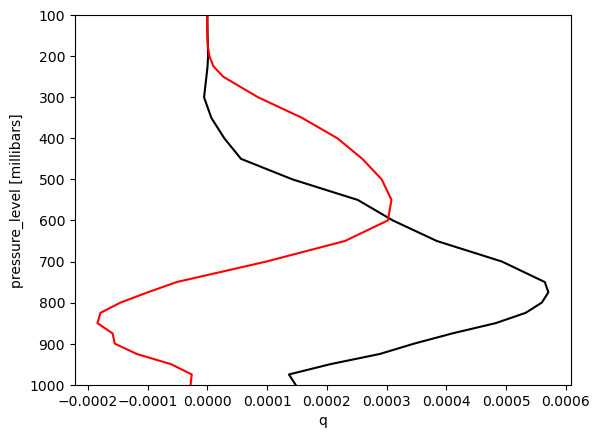

In [114]:
(ds_xr.sel(sp_loc='It_Ip')-ds_xr.sel(sp_loc='It_Ep')).mean('tracks').q.plot(y='level', color='k', label='Initial S')
(ds_xr.sel(sp_loc='Et_Ep')-ds_xr.sel(sp_loc='It_Ep')).mean('tracks').q.plot(y='level', color='r', label='Initial E')
#(ds_xr.sel(sp_loc='Et_Ep')).mean('tracks').q.plot(y='level', color='m', label='End E')
plt.ylim([1000,100])

(1000.0, 100.0)

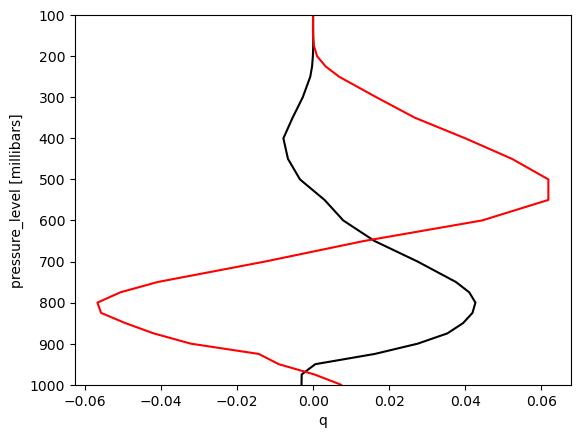

In [116]:
(1000*(ds_SL_xr.sel(sp_loc='It_Ip')-ds_SL_xr.sel(sp_loc='It_Ep'))).mean('tracks').q.plot(y='level', color='k', label='Initial S')
(1000*(ds_SL_xr.sel(sp_loc='Et_Ep')-ds_SL_xr.sel(sp_loc='It_Ep'))).mean('tracks').q.plot(y='level', color='r', label='Initial E')
#(ds_xr.sel(sp_loc='Et_Ep')).mean('tracks').q.plot(y='level', color='m', label='End E')
plt.ylim([1000,100])

(1000.0, 100.0)

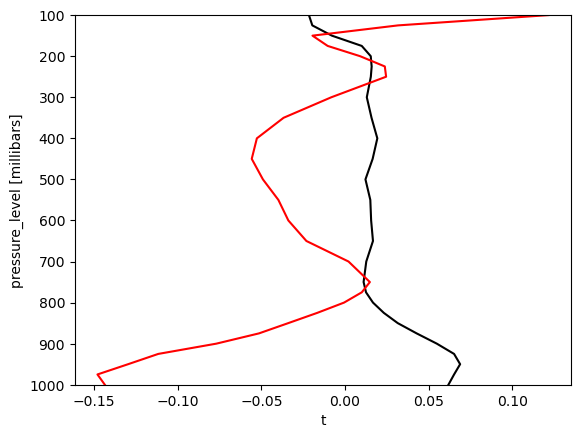

In [117]:
((ds_SL_xr.sel(sp_loc='It_Ip')-ds_SL_xr.sel(sp_loc='It_Ep'))).mean('tracks').t.plot(y='level', color='k', label='Initial S')
((ds_SL_xr.sel(sp_loc='Et_Ep')-ds_SL_xr.sel(sp_loc='It_Ep'))).mean('tracks').t.plot(y='level', color='r', label='Initial E')
#(ds_xr.sel(sp_loc='Et_Ep')).mean('tracks').q.plot(y='level', color='m', label='End E')
plt.ylim([1000,100])